## Download Data

You can access the AHN data (Actueel Hoogtebestand Nederland) trough their [website](https://www.ahn.nl/ahn-4) and de [ESRI Explorer](https://hub.arcgis.com/maps/esrinl-content::ahn4-download-kaartbladen-1/explore). To download, simply click on one of the tiles and select the data you want to download. In this case we are going to work with a **DTM 5m** resolution.

## Clip the area

#### Import the necesary libraries



In [19]:
import pickle
import trimesh as tm
import math
import numpy as np
import open3d as o3d
import matplotlib.pyplot as plt

In [2]:
## load result from previous notebook using pickle
with open('mesh.pkl','rb') as file:
    mesh = pickle.load(file)

mesh.show()

In [14]:
## Use mathematical spherical coordinateshttps://en.wikipedia.org/wiki/Spherical_coordinate_system
T=180 # Theta counter - Azimuth Angles
K=45 # Phi counter - Elevation Angles
r=10 #size of dome
hemisphereVertices = []

for t in range (T):
    for k in range(K):
        theta = (float(t/T))*math.pi*2
        phi= (float(k/K))*math.pi/2
        x = r*math.sin(phi)*math.cos(theta)
        y = r*math.sin(phi)*math.sin(theta)
        z = r*math.cos(phi)
        hSVertex = [x,y,z]
        #print(theta,phi,z)

        hemisphereVertices.append(hSVertex)
        
#hemisphereVertices

In [15]:
domePC = o3d.geometry.PointCloud()
domePC.points = o3d.utility.Vector3dVector(hemisphereVertices)
o3d.visualization.draw_geometries([domePC])

### Now lets do it with NP Meshgrids

In [18]:
nt,nk=(180,45)
thetaArray = np.linspace(0,2*np.pi,nt) 
phiArray = np.linspace(0,np.pi/2,nk)

thetaGrid, phiGrid = np.meshgrid(thetaArray,phiArray) 

array([[0.        , 0.03510159, 0.07020319, ..., 6.21298212, 6.24808371,
        6.28318531],
       [0.        , 0.03510159, 0.07020319, ..., 6.21298212, 6.24808371,
        6.28318531],
       [0.        , 0.03510159, 0.07020319, ..., 6.21298212, 6.24808371,
        6.28318531],
       ...,
       [0.        , 0.03510159, 0.07020319, ..., 6.21298212, 6.24808371,
        6.28318531],
       [0.        , 0.03510159, 0.07020319, ..., 6.21298212, 6.24808371,
        6.28318531],
       [0.        , 0.03510159, 0.07020319, ..., 6.21298212, 6.24808371,
        6.28318531]])

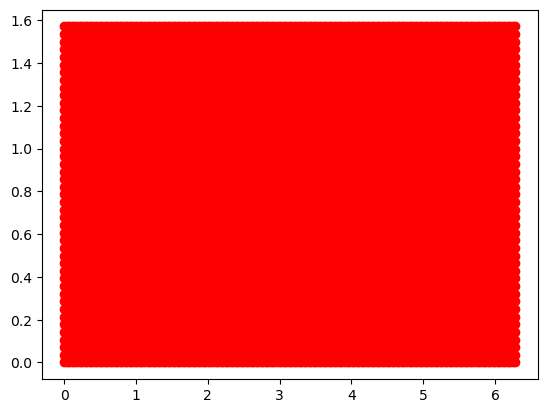

In [20]:
plt.plot(thetaGrid, phiGrid, marker='o', color='r', linestyle='none')
plt.show()

In [70]:
def Spherical2Cartesian (r,theta,phi):
    x = r*np.sin(phi)*np.cos(theta)
    y = r*np.sin(phi)*np.sin(theta)
    z = r*np.cos(phi)
    return np.array([x,y,z])

CartesianPoints = Spherical2Cartesian(r,thetaGrid,phiGrid)
CartesianPointsR= CartesianPoints.reshape(3,-1).T # reshape and transpose
CartesianPointsT = CartesianPoints.T
CartesianPointsT.shape


(180, 45, 3)

In [45]:
#Visualize Points in 3D
domeMesh = o3d.geometry.PointCloud()
domeMesh.points = o3d.utility.Vector3dVector(CartesianPointsR)
o3d.visualization.draw_geometries([domeMesh])

In [68]:
### create Rays for all points in dome

In [ ]:
vertex = np.array([0,0,0])
rays = np.broadcast_to(vertex, CartesianPoints.T.shape)
rays


In [87]:
vertex=mesh.vertices[123]

In [89]:
# vertex = np.array([0,0,0])

rayDirections=(CartesianPointsT-vertex).reshape(-1,3)
rayOrigins = np.broadcast_to(vertex, rayDirections.shape)
# for t in range(T):
#     for k in range(K):
#         hsPoint = CartesianPointsT[t,k,:]
#         ray = (vertex,hsPoint)
hitLocations,indexRay, indexTriangle= mesh.ray.intersects_location(ray_origins=rayOrigins,ray_directions=rayDirections)

hitLocations.shape,indexRay.shape
# rayDirections.shape




((360, 3), (360,))

In [91]:
ray_visualize = tm.load_path(np.hstack((rayOrigins,rayOrigins+ rayDirections*5.0)).reshape(-1, 2, 3))
# unmerge so viewer doesn't smooth
mesh.unmerge_vertices()
# make mesh white- ish
mesh.visual.face_colors = [255,255,255,255]
mesh.visual.face_colors[indexTriangle] = [255, 0, 0, 255]

# create a visualization scene with rays, hits, and mesh
scene = tm.Scene([mesh,
                       ray_visualize])
scene.show()
